In [1]:
import pandas
import pathlib
from config import datadir
import numpy
import matplotlib.pyplot as plt
from latex_figure import plotfigure
import scipy.signal as sig
import statsmodels.nonparametric.smoothers_lowess as smoother

In [2]:
import pint

In [3]:
excel_directory = pandas.read_excel(datadir/'Data Description.xlsx', parse_dates=True, index_col='Start Date')
excel_directory

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe Drift, circulating ph7 bu..."
2019-12-17,2019-12-23,pH Probe,Drift,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe drift, performed inside t..."
2020-01-16,2020-01-16,pH Probe,Step Test,Step Test,20200116 pH Step 3.txt,3,pH stepped outside of rig
2020-01-14,2020-01-14,pH Probe,Step Test,Step Test,20200116 pH Step 1.txt,1,"pH stepped outside of rig. Probe Broke, Dump run"
2020-01-15,2020-01-15,pH Probe,Step Test,Step Test,20200116 pH Step 2.txt,2,pH stepped outside of rig


In [4]:
drifts = excel_directory[(excel_directory['Type']=='Drift')]   #Use '&' for multiple conditions
drifts

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe Drift, circulating ph7 bu..."
2019-12-17,2019-12-23,pH Probe,Drift,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe drift, performed inside t..."


In [5]:
all_drifts_frames =[]
durations = []
for file in drifts['Filename']:
    new_frame = pandas.read_csv(datadir /file, 
                               sep ='\t',header = None,
                               usecols = [0, 1, 2, 3],
                               names = ["Date", "Time", "Temp", "pH"])
    
    durations.append([new_frame.index[0],new_frame.index[-1]])
    
    new_frame['DateTime'] = new_frame['Date'].astype(str) +' '+ new_frame['Time'].astype(str)
    new_frame['DateTime'] = pandas.to_datetime(new_frame['DateTime'], format = r'%Y/%m/%d %I:%M:%S %p')
    new_frame = new_frame.drop(columns=['Date','Time']).set_index('DateTime')
    
    new_frame['Temp'] = new_frame['Temp'].astype('pint[degC]') #Allows setting of units for data types
    new_frame['Temp'] = new_frame['Temp'].pint.to('kelvin')
    
    all_drifts_frames.append(new_frame)
        
#     print (file)

In [6]:
Skip_first = 100000

In [7]:
times = []
ph = []
delta_times = []
for frame in all_drifts_frames:
    times.append(frame.index[Skip_first:])
    ph.append(frame['pH'].values[Skip_first:])
    delta_times.append((frame.index[Skip_first:] - frame.index[0]).astype('timedelta64[s]'))
    
# print (times, ph, delta_times)

### Ploting Settings

In [8]:
# Names and line types for the different plot series
YNAMES = ["Run 1", "Run 2", "Run 3", "Run 1 Filtered - 1", "Run 1 Filtered - 2"]
LINETYPES = ["k-", "b-", "g-", 'y-', 'r-']

aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

xlabel = "Time since Start /s"
ylabel = "pH"

F:\Varsity\CSC\Jarryd CSC\latex_figure.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
F:\Varsity\CSC\Jarryd CSC\latex_figure.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(filename.format(diff="model"))
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


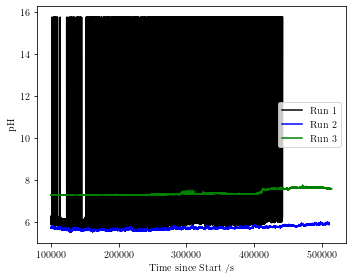

In [9]:
plotfigure(delta_times, ph, YNAMES, LINETYPES, xlabel, ylabel, figsize=FULLSIZE, filename=str(datadir)+"/pH Drifts.pdf")
# plotfigure(times, temps, figsize=HALFSIZE, filename=str(datadir)+"/samplefigure_halfsize.pdf")

In [10]:
ph_filtered = [sig.savgol_filter(all_drifts_frames[0]['pH'][Skip_first:],100001,3)]
time_for_filtered = [all_drifts_frames[0].index[Skip_first:]]

In [11]:
frame = all_drifts_frames[0].copy()

In [12]:
frame['deltas'] = (frame.index-frame.index[0]).astype('timedelta64[s]')
frame['ph_shift'] = frame['pH'].shift(1)

In [13]:
allowed_change=0.05
cutoff = 7

In [14]:
drops = frame['pH'][((frame['pH']-frame['ph_shift'])>allowed_change*frame['ph_shift']) | (frame['pH']>cutoff)].index #(frame['pH']<10) & 

In [15]:
mask = ~numpy.in1d(frame.index, drops)
frame_trimmed = frame.loc[mask, :]

In [16]:
ph.append(ph_filtered[0])

delta_times.append(delta_times[0])

ph.append(frame_trimmed['pH'][Skip_first:])

delta_times.append(frame_trimmed['deltas'][Skip_first:])

F:\Varsity\CSC\Jarryd CSC\latex_figure.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
F:\Varsity\CSC\Jarryd CSC\latex_figure.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(filename.format(diff="model"))
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


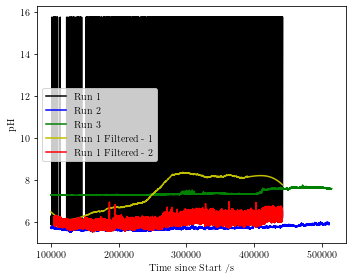

In [17]:
plotfigure(delta_times, ph, YNAMES, LINETYPES, xlabel, ylabel, figsize=FULLSIZE, filename=str(datadir)+"/pH Drifts.pdf")
# plotfigure(times, temps, figsize=HALFSIZE, filename=str(datadir)+"/samplefigure_halfsize.pdf")